# Import Libraries

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, MaxPooling3D, TimeDistributed, Dropout
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Bidirectional, LSTM
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard


from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

2025-08-03 14:24:53.995734: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-03 14:24:54.296713: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-03 14:24:54.296761: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-03 14:24:54.353706: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-03 14:24:54.477656: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-03 14:24:54.480149: I tensorflow/core/platform/cpu_feature_guard.cc:1

# 1. Code Configurations

In [2]:
VIDEO_DIR = "UCF50"
FRAMES_PER_CLIP = 25
IMAGE_SIZE = (64, 64)

# 2. Select Action Recognition Categories

In [3]:
# Choose actions to train on
selected_actions = ["Basketball", "Biking", "HorseRiding"]

In [4]:
# Setup the labels dictionary for the selected actions
label_dict = {}                                                     # {'action_name': idx}
for idx, action in enumerate(selected_actions):
    label_dict[action] = idx

# 3. Extract Video Frames

In [5]:
# This function extracts a specific number of evenly-spaced frames from a video file
def extract_video_frames(filepath):
    # Open the video file using OpenCV's VideoCapture
    capture = cv2.VideoCapture(filepath)
    # Get the total number of frames in the video
    total_frames = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # If the video has fewer frames than needed, return None
    if total_frames < FRAMES_PER_CLIP:
        capture.release()
        return None

    # Create an array of evenly-spaced frame indices to extract
    selected_frames = np.linspace(0, total_frames-1, FRAMES_PER_CLIP, dtype=int)
    frames_list = []                                                # list of frames

    # Loop through each selected frame index
    for frame_num in selected_frames:
        # Set the video position to the current frame number
        capture.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
        # Read the frame at the current position
        success, frame = capture.read()
        # If frame couldn't be read, abort and return None
        if not success:
            capture.release()
            return None
        # Resize the frame to the dimensions specified by IMAGE_SIZE
        frame_resized = cv2.resize(frame, IMAGE_SIZE)
        # Add the resized frame to the collection
        frames_list.append(frame_resized)

    # Properly close the video file
    capture.release()
    
    # Return the collection of frames as a NumPy array
    return np.array(frames_list)

# 4. Create the Dataset

In [6]:
# Initialize empty lists to store processed video data and corresponding labels
all_videos, all_labels = [], []

# Iterate through each action category and its assigned ID from the label dictionary
for action, action_id in label_dict.items():
    # Construct the path to the folder containing videos for the current action
    action_folder = os.path.join(VIDEO_DIR, action)
    
    # Iterate through each video file in the current action folder
    for vid_file in os.listdir(action_folder):
        # Create the full path to the current video file
        clip_path = os.path.join(action_folder, vid_file)
        
        # Extract frames from the current video using the extraction function
        frames = extract_video_frames(clip_path)
        
        # Only process videos that returned valid frames
        if frames is not None:
            all_videos.append(frames)                               # Add the extracted frames to our collection of processed videos
            all_labels.append(action_id)                            # Store the corresponding action ID (label) for this video

# 5. Data Pre-processing

In [7]:
# Convert the list of videos to a numpy array and normalize pixel values
all_videos = np.array(all_videos).astype('float32') / 255.0

# Convert integer labels to one-hot encoded vectors
all_labels = to_categorical(all_labels, num_classes=len(label_dict))

# 6. Data Preparation

In [8]:
# Split data
train_videos, test_videos, train_labels, test_labels = train_test_split(all_videos, all_labels, test_size=0.25, random_state=123, stratify=all_labels)

In [9]:
# Input shape handling
train_videos = train_videos.reshape(-1, FRAMES_PER_CLIP, IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
test_videos = test_videos.reshape(-1, FRAMES_PER_CLIP, IMAGE_SIZE[0], IMAGE_SIZE[1], 3)

# 7. Model Architecture

In [10]:
def create_convlstm_model():
    '''
    This function creates a ConvLSTM model for video classification.
    The model combines ConvLSTM2D layers for spatio-temporal feature extraction with additional layers for better performance.
    
    Returns:
        model: The constructed improved ConvLSTM model.
    '''
    
    # 1. Initialize a Sequential model
    model = Sequential()
    
    # 2. Model Architecture
    # ---------------------
    # 2.1. ConvLSTM2D Layer 1 - with Batch Normalization
    model.add(ConvLSTM2D(filters=4, kernel_size=(3, 3), activation='tanh',
                         data_format='channels_last', recurrent_dropout=0.2, return_sequences=True,
                         input_shape=(FRAMES_PER_CLIP, IMAGE_SIZE[0], IMAGE_SIZE[1], 3)))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    # 2.2. ConvLSTM2D Layer 2 - with Batch Normalization
    model.add(ConvLSTM2D(filters=8, kernel_size=(3, 3), activation='tanh',
                         data_format='channels_last', recurrent_dropout=0.2, return_sequences=True))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    # 2.3. ConvLSTM2D Layer 3 - with Batch Normalization
    model.add(ConvLSTM2D(filters=16, kernel_size=(3, 3), activation='tanh',
                         data_format='channels_last', recurrent_dropout=0.2, return_sequences=True))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    # 2.4. ConvLSTM2D Layer 4 - with Batch Normalization
    model.add(ConvLSTM2D(filters=32, kernel_size=(3, 3), activation='tanh',
                         data_format='channels_last', recurrent_dropout=0.2, return_sequences=True))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    # 2.5. Add regular LSTM layer to further process temporal data
    model.add(Flatten())                                       # Flatten the output of the ConvLSTM layers
    
    # 2.6. Fully Connected Dense Layer for Classification
    model.add(Dense(256, activation='tanh'))
    model.add(Dropout(0.4))
    model.add(Dense(len(label_dict), activation='softmax'))
    # ---------------------
    
    # 3. Display the model summary
    model.summary()
    
    return model

In [11]:
# Create the ConvLSTM model
convlstm_model = create_convlstm_model()

2025-08-03 14:26:08.716015: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-08-03 14:26:08.716514: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 25, 62, 62, 4)     1024      
                                                                 
 batch_normalization (Batch  (None, 25, 62, 62, 4)     16        
 Normalization)                                                  
                                                                 
 max_pooling3d (MaxPooling3  (None, 25, 31, 31, 4)     0         
 D)                                                              
                                                                 
 time_distributed (TimeDist  (None, 25, 31, 31, 4)     0         
 ributed)                                                        
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 25, 29, 29, 8)     3488      
                                                        

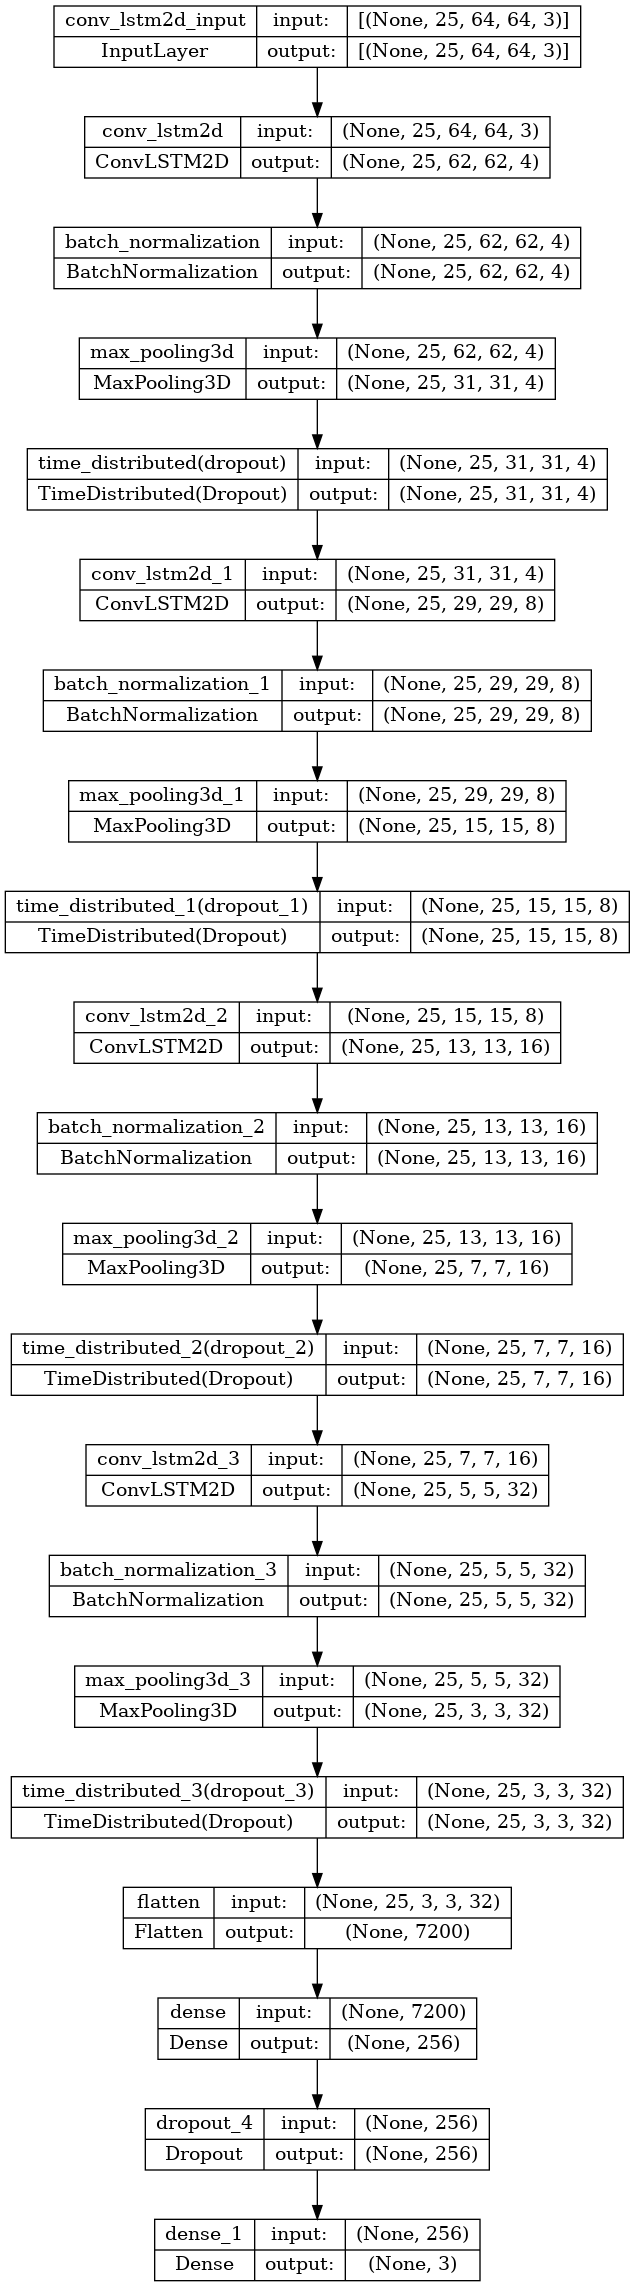

In [23]:
# Plot the Network
from IPython.display import Image
from tensorflow.keras.utils import plot_model

plot_model(convlstm_model, to_file="convlstm_architecture.png", show_shapes=True)
Image(filename="convlstm_architecture.png")

# 8. Model Training

In [12]:
def f1_score(y_true, y_pred):
    y_pred = tf.round(y_pred)
    tp = tf.reduce_sum(tf.cast(y_true * y_pred, 'float'))
    fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, 'float'))
    fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), 'float'))
    precision = tp / (tp + fp + 1e-7)
    recall = tp / (tp + fn + 1e-7)
    return 2 * precision * recall / (precision + recall + 1e-7)

In [18]:
def train_convlstm_model(model, train_data, train_targets, 
                         learning_rate=0.001, validation_split=0.2, 
                         epochs=70, batch_size=8):
    """
    Train a ConvLSTM video classification model on sequence/video data.

    Args:
        model: Compiled Keras model.
        train_data: Training video data (numpy array of shape [N, T, H, W, C]).
        train_targets: Categorical labels (one-hot encoded or integer labels).
        learning_rate: Learning rate for Adam optimizer.
        validation_split: Fraction of training data for validation.
        epochs: Number of training epochs.
        batch_size: Batch size for training.

    Returns:
        history: Training history object.
    """

    model.compile(
                    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                    loss='categorical_crossentropy',
                    metrics=[
                                'accuracy',
                                tf.keras.metrics.Precision(name='precision'),
                                tf.keras.metrics.Recall(name='recall'),
                                tf.keras.metrics.AUC(name='auc', multi_label=True),
                            ]
    )

    callbacks = [
                    tf.keras.callbacks.EarlyStopping(
                                                        monitor='val_loss',
                                                        patience=10,
                                                        restore_best_weights=True
                                                    ),
                    tf.keras.callbacks.ReduceLROnPlateau(
                                                            monitor='val_loss',
                                                            factor=0.5,
                                                            patience=5,
                                                            min_lr=1e-6
                                                        )
                ]

    history = model.fit(
                            train_data,
                            train_targets,
                            epochs=epochs,
                            validation_split=validation_split,
                            batch_size=batch_size,
                            shuffle=True,
                            callbacks=callbacks,
                            verbose=1
                    )

    return history

# 9. Train the Model

In [20]:
convlstm__model_training_history = train_convlstm_model(
                                                    model = convlstm_model,
                                                    train_data = train_videos,
                                                    train_targets = train_labels,
                                                    learning_rate = 0.001,
                                                    validation_split = 0.2,
                                                    epochs=70,
                                                    batch_size=4)

Epoch 1/70
70/70 [==============================] - 44s 533ms/step - loss: 1.3164 - accuracy: 0.4714 - precision: 0.4750 - recall: 0.4071 - auc: 0.6255 - val_loss: 1.3058 - val_accuracy: 0.4789 - val_precision: 0.4853 - val_recall: 0.4648 - val_auc: 0.6482 - lr: 0.0010
Epoch 2/70
70/70 [==============================] - 38s 541ms/step - loss: 1.3676 - accuracy: 0.4286 - precision: 0.4375 - recall: 0.4000 - auc: 0.6119 - val_loss: 1.7436 - val_accuracy: 0.2535 - val_precision: 0.2500 - val_recall: 0.2394 - val_auc: 0.5043 - lr: 0.0010
Epoch 3/70
70/70 [==============================] - 37s 523ms/step - loss: 1.2008 - accuracy: 0.4964 - precision: 0.5125 - recall: 0.4393 - auc: 0.6847 - val_loss: 1.7864 - val_accuracy: 0.2676 - val_precision: 0.2676 - val_recall: 0.2676 - val_auc: 0.6083 - lr: 0.0010
Epoch 4/70
70/70 [==============================] - 36s 511ms/step - loss: 1.2772 - accuracy: 0.5321 - precision: 0.5488 - recall: 0.4821 - auc: 0.6810 - val_loss: 1.0977 - val_accuracy: 0.4

# 10. Plot Results

## 10.1. Plotting Function

In [21]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    Function to plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation 
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''
    
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

## 10.2. Curves

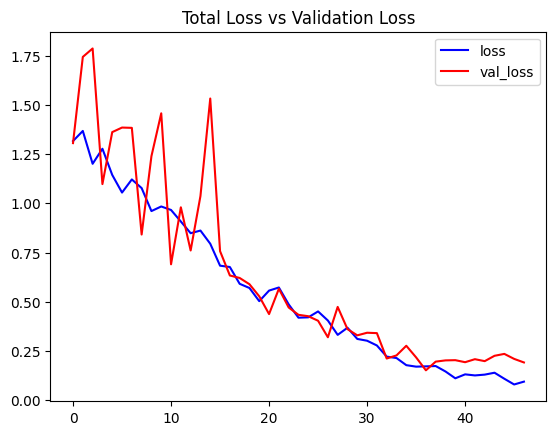

In [25]:
# Visualize the training and validation loss metrices.
plot_metric(convlstm__model_training_history, 'loss', 'val_loss', 'Total Loss vs Validation Loss')

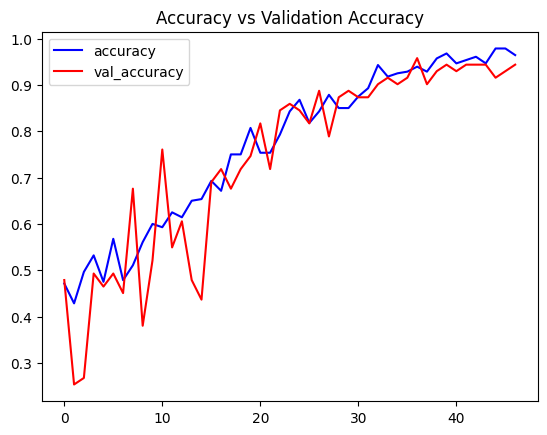

In [27]:
# Visualize the training and validation accuracy metrices.
plot_metric(convlstm__model_training_history, 'accuracy', 'val_accuracy', 'Accuracy vs Validation Accuracy')

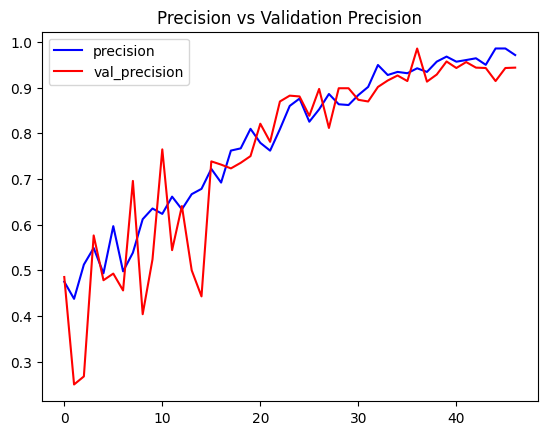

In [28]:
# Visualize the training and validation precision metrices.
plot_metric(convlstm__model_training_history, 'precision', 'val_precision', 'Precision vs Validation Precision')

# 11. Final Evaluation

In [24]:
# Evaluate the model on the test set
test_results = convlstm_model.evaluate(test_videos, test_labels, verbose=0)
test_metrics = dict(zip(convlstm_model.metrics_names, test_results))

print("\nTest Set Metrics:")
for name, value in test_metrics.items():
    print(f"{name}: {value:.4f}")


Test Set Metrics:
loss: 0.4068
accuracy: 0.8390
precision: 0.8462
recall: 0.8390
auc: 0.9665


# 12. Save the Model

In [30]:
# 13. Save (Optional, renamed for difference)
convlstm_model.save("action_classifier_model_v1.keras")